## 常用模型调参方法

### 贪心算法

- 不多bb，就是那五个经典算法里的贪心算法
- 前提：局部最优策略能导致产生全局最优解

### 网格搜索 Grid Search

- 好像就是穷举的亚子，缺点不言而喻
- 所谓GridSearchCV，穷举+交叉验证

### 贝叶斯调参 

- 看字面意思应该就是用贝叶斯不断更新某种先验的方法

- 基于数据使用贝叶斯定理估计目标函数的后验分布，然后再根据分布选择下一个采样的超参数组合。

它充分利用了前一个采样点的信息，其优化的工作方式是通过对目标函数形状的学习，并找到使结果向全局最大提升的参数。

### 贝叶斯优化与前两者的区别

与常规的网格搜索或者随机搜索的区别是：

- 贝叶斯调参采用高斯过程，考虑之前的参数信息，不断地更新先验；网格搜索未考虑之前的参数信息
- 贝叶斯调参迭代次数少，速度快；网格搜索速度慢,参数多时易导致维度爆炸
- 贝叶斯调参针对非凸问题依然稳健；网格搜索针对非凸问题容易陷入局部最优

## 导入数据


In [2]:
#coding:utf-8
#导入warnings包，利用过滤器来实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

%matplotlib inline

？？？

In [4]:
# 通过调整数据类型，帮助我们减少数据在内存中占用的空间

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

Memory usage of dataframe is 62099672.00 MB
Memory usage after optimization is: 16520303.00 MB
Decreased by 73.4%


In [7]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

In [9]:
continuous_feature_names

['SaleID',
 'bodyType',
 'fuelType',
 'gearbox',
 'kilometer',
 'name',
 'notRepairedDamage',
 'offerType',
 'power',
 'seller',
 'train',
 'v_0',
 'v_1',
 'v_10',
 'v_11',
 'v_12',
 'v_13',
 'v_14',
 'v_2',
 'v_3',
 'v_4',
 'v_5',
 'v_6',
 'v_7',
 'v_8',
 'v_9',
 'used_time',
 'city',
 'brand_amount',
 'brand_price_max',
 'brand_price_median',
 'brand_price_min',
 'brand_price_sum',
 'brand_price_std',
 'brand_price_average',
 'power_bin']

## OLS 

In [12]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']


In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(normalize=True)
model = model.fit(train_X, train_y)

# 查看结局和系数
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367064.341641869),
 ('v_8', 700675.5609398916),
 ('v_9', 170630.2772322144),
 ('v_7', 32322.66193202752),
 ('v_12', 20473.670796962964),
 ('v_3', 17868.07954149201),
 ('v_11', 11474.938996740202),
 ('v_13', 11261.764560011892),
 ('v_10', 2683.9200905552707),
 ('gearbox', 881.8225039249025),
 ('fuelType', 363.90425072165164),
 ('bodyType', 189.60271012073065),
 ('city', 44.94975120522174),
 ('power', 28.553901616752594),
 ('brand_price_median', 0.5103728134078995),
 ('brand_price_std', 0.45036347092633167),
 ('brand_amount', 0.14881120395065975),
 ('brand_price_max', 0.0031910186703138377),
 ('SaleID', 5.35598991985751e-05),
 ('seller', 4.227447789162397e-06),
 ('offerType', 1.965701812878251e-06),
 ('train', -1.5418627299368382e-06),
 ('brand_price_sum', -2.1750068681876972e-05),
 ('name', -0.0002980012713042195),
 ('used_time', -0.0025158943328787604),
 ('brand_price_average', -0.40490484510115926),
 ('brand_price_min', -2.2467753486893227),
 ('power_bin', -34.42064411725974

The predicted price is obvious different from true price


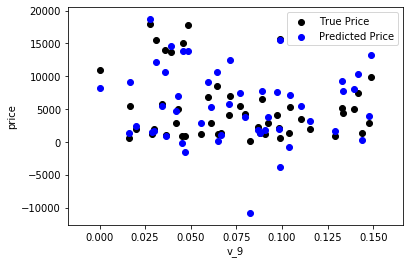

In [14]:
from matplotlib import pyplot as plt

subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

标签并不服从正态分布，不满足OLS的基本假设

It is clear to see the price shows a typical exponential distribution


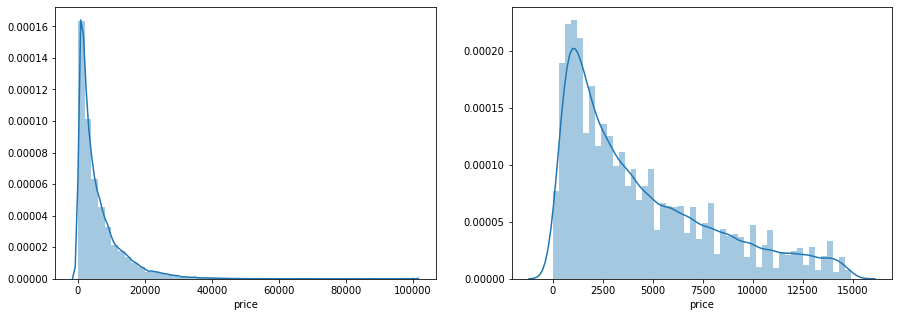

In [16]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

The transformed price seems like normal distribution


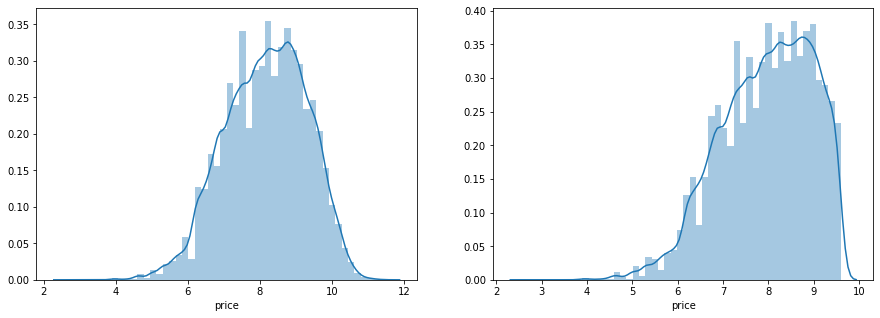

In [17]:
# 对数变换
train_y_ln = np.log(train_y + 1)

import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [18]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.7507494655882


[('v_9', 8.052409900566975),
 ('v_5', 5.76423659665043),
 ('v_12', 1.6182081236808878),
 ('v_1', 1.4798310582957113),
 ('v_11', 1.1669016563630523),
 ('v_13', 0.9404711296035345),
 ('v_7', 0.7137273083560814),
 ('v_3', 0.6837875771090364),
 ('v_0', 0.008500518010179769),
 ('power_bin', 0.008497969302895196),
 ('gearbox', 0.007922377278325341),
 ('fuelType', 0.00668476970683032),
 ('bodyType', 0.004523520092704702),
 ('power', 0.000716189420535513),
 ('brand_price_min', 3.3343511147504113e-05),
 ('brand_amount', 2.8978797042776285e-06),
 ('brand_price_median', 1.2571172873047128e-06),
 ('brand_price_std', 6.659176363479574e-07),
 ('brand_price_max', 6.194956307516032e-07),
 ('brand_price_average', 5.999345965001714e-07),
 ('SaleID', 2.1194170039653628e-08),
 ('seller', 1.665849680421161e-10),
 ('train', -1.8616219676914625e-11),
 ('offerType', -8.449063670923351e-11),
 ('brand_price_sum', -1.5126504215926567e-10),
 ('name', -7.015512588899606e-08),
 ('used_time', -4.122479372350831e-06)

The predicted price seems normal after np.log transforming


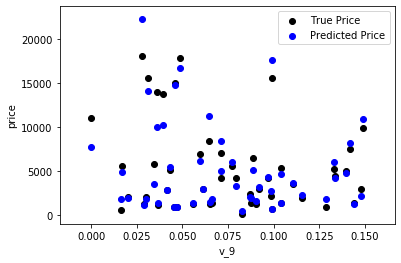

In [19]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

## 5-fold CV

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

scores = cross_val_score(model, X=train_X, y=train_y, 
                         verbose=1, cv = 5, 
                         scoring=make_scorer(log_transfer(mean_absolute_error)))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [23]:
# 未处理标签
print('AVG:', np.mean(scores))

AVG: 1.3658023920313966


In [25]:
# 处理标签
scores = cross_val_score(model, X=train_X, y=train_y_ln, 
                         verbose=1, cv = 5, 
                         scoring=make_scorer(mean_absolute_error))

print('AVG:', np.mean(scores))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AVG: 0.19325301837047443


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [26]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


## 模拟真实业务情况

靠前时间的4/5样本当作训练集，靠后时间的1/5当作验证集

In [30]:
import datetime

sample_feature = sample_feature.reset_index(drop=True)
split_point = len(sample_feature) // 5 * 4

train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)


In [31]:
model = model.fit(train_X, train_y_ln)
mean_absolute_error(val_y_ln, model.predict(val_X))

0.1957766727030098

和 5-fold CV 的结果相差不多

In [34]:
from sklearn.model_selection import learning_curve, validation_curve

In [36]:
# ? learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

<module 'matplotlib.pyplot' from 'D:\\Tools\\Anaconda\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

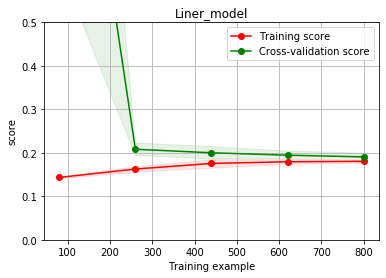

In [37]:
plot_learning_curve(LinearRegression(), 'Liner_model', 
                    train_X[:1000], train_y_ln[:1000], 
                    ylim=(0.0, 0.5), cv=5, n_jobs=1)  

## 多种模型对比

In [40]:
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

## Ridge Regression & Lasso

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

models = [LinearRegression(),
          Ridge(),
          Lasso()]

result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


In [42]:
# 合并结果对比

result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.190792,0.194832,0.383899
cv2,0.193758,0.197632,0.381893
cv3,0.194132,0.198123,0.384090
cv4,0.191825,0.195670,0.380526
cv5,0.195758,0.199676,0.383611


intercept:18.750749399255973


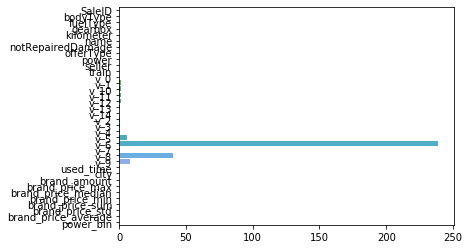

In [43]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:4.671709787502074


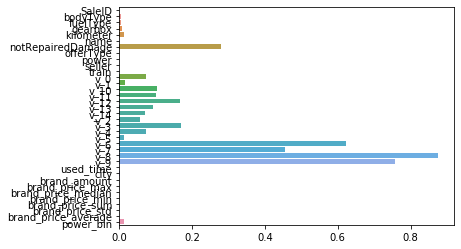

In [44]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:8.672182402894254


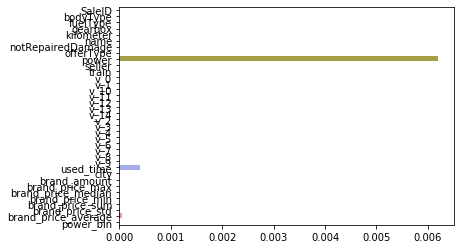

In [45]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

## 非线性模型

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [59]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]

In [60]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished
XGBRegressor is finished
LGBMRegressor is finished


In [61]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.190792,0.199166,0.141521,0.168902,373.579871,0.142333,0.141546
cv2,0.193758,0.192577,0.142775,0.171831,655.556391,0.140987,0.145501
cv3,0.194132,0.190103,0.140970,0.170936,1058.180747,0.139266,0.143887
cv4,0.191825,0.189364,0.141615,0.169083,217.252263,0.137399,0.142497
cv5,0.195758,0.204556,0.146772,0.174078,505.687178,0.143998,0.144852


## 模型调参

In [62]:
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

## 贪心调参

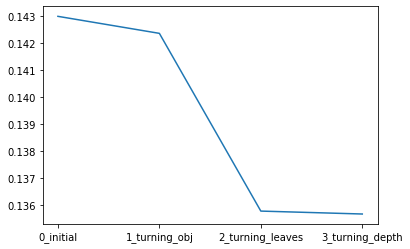

In [63]:
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], 
             y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

## 网格搜索调参

In [65]:
from sklearn.model_selection import GridSearchCV

parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

clf.best_params_



{'max_depth': 15, 'num_leaves': 55, 'objective': 'regression'}

In [67]:

model = LGBMRegressor(objective='regression',
                          num_leaves=55,
                          max_depth=15)

np.mean(cross_val_score(model, X=train_X, y=train_y_ln, 
                        verbose=0, cv = 5, 
                        scoring=make_scorer(mean_absolute_error)))

0.13754820909576437

===

小问号，你是否有很多朋友

## 贝叶斯调参

In [72]:
from bayes_opt import BayesianOptimization

def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val


rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)


rf_bo.maximize()

|   iter    |  target   | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        |  0.8595   |  11.6     |  97.44    |  36.2     |  0.9102   |
|  2        |  0.8625   |  12.45    |  99.19    |  46.15    |  0.941    |
|  3        |  0.856    |  35.3     |  33.52    |  27.36    |  0.4932   |
|  4        |  0.8665   |  17.28    |  8.559    |  70.5     |  0.3443   |
|  5        |  0.8571   |  8.075    |  51.23    |  30.73    |  0.9453   |
|  6        |  0.8693   |  98.97    |  88.05    |  99.49    |  0.3731   |
|  7        |  0.8062   |  2.126    |  99.18    |  99.28    |  0.8433   |
|  8        |  0.8692   |  97.36    |  3.244    |  98.72    |  0.9723   |
|  9        |  0.8273   |  99.44    |  95.69    |  6.925    |  0.1247   |
|  10       |  0.8691   |  97.67    |  86.94    |  95.16    |  0.8255   |
|  11       |  0.83     |  4.104    |  4.165    |  7.224    |  0.6755   |
|  12       |  0.8688   |  98.16    | 

In [73]:
1 - rf_bo.max['target']

0.13050870817093485

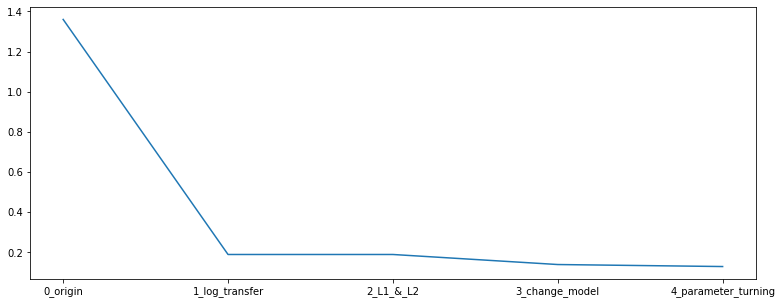

In [74]:
plt.figure(figsize=(13,5))
sns.lineplot(x=['0_origin','1_log_transfer','2_L1_&_L2','3_change_model','4_parameter_turning'], y=[1.36 ,0.19, 0.19, 0.14, 0.13])